In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import EntropyRateSuperpixel as ERS
import MyDataset as Data
import LambdaCoeff as LC

import SSGA

145 145 200


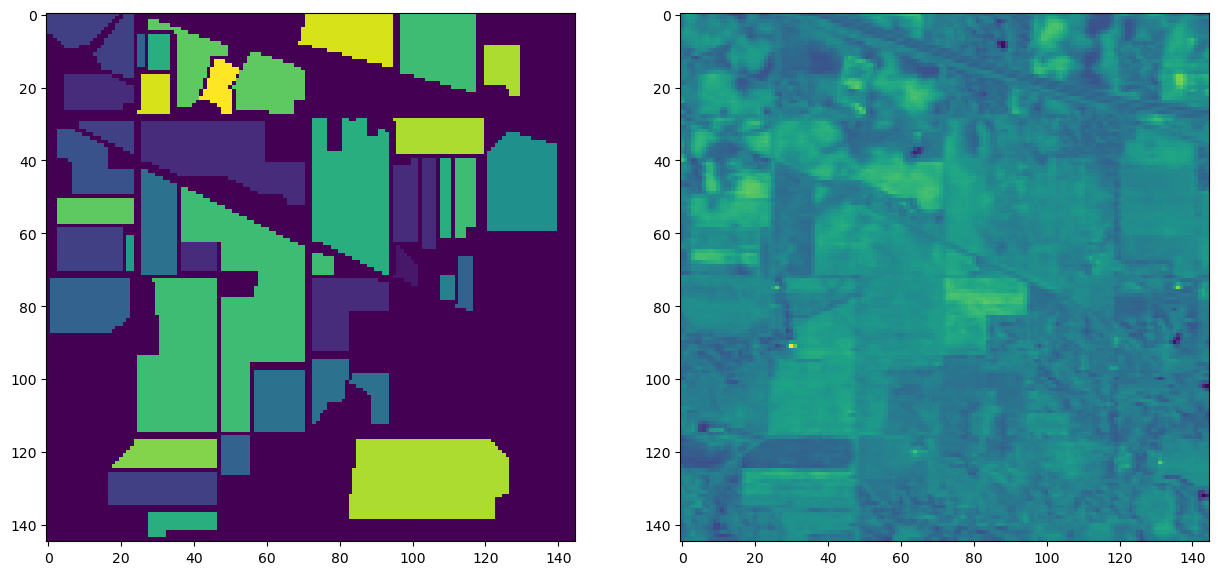

In [2]:
usedDataset = Data.IndianPines
#usedDataset = Data.PaviaUniversity
#usedDataset = Data.PaviaCenter


N,M,B = usedDataset["shape"]
trainData = usedDataset["data"]
print(N,M,B)
trainData = Data.standardize_data(trainData)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(usedDataset["gt"])
axs[1].imshow(np.average(usedDataset["data"], axis=2))
plt.show()

### Choice of Ks

In [19]:
Ks = [20, 50, 100, 200, 400]
Ks.sort()

### Compute SPs

In [20]:
SPsDic = ERS.find_superpixel(trainData, Ks,
                             lambda_coef="auto",
                             simFun="norm1")

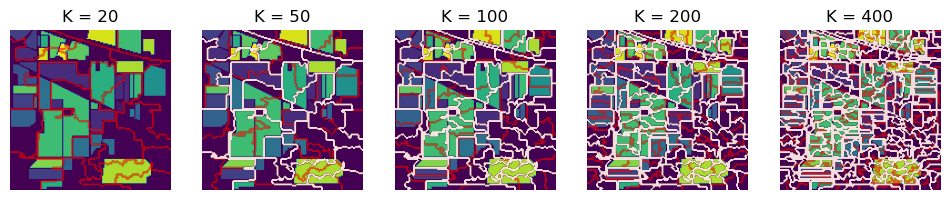

In [21]:
n,m = 1,5
Ks_id_to_plot = np.unique(np.round(np.linspace(0,len(Ks)-1, n*m)).astype(int))
Ks2D = np.array([Ks[i] for i in Ks_id_to_plot]).reshape(n,m)

fig, axs = plt.subplots(n, m, figsize=(12,6))
axs = axs.reshape(n,m)
for i in range(n):
    for j in range(m):
        axs[i,j].axis("off")
        axs[i,j].imshow(usedDataset["gt"])
        axs[i,j].imshow(ERS.create_overlay_borders(usedDataset["gt"], SPsDic[Ks2D[i,j]], color=[255,0,0,150]))
        if i+j>0:
            pred = (i,j-1) if j>0 else (i-1, m-1)
            axs[i,j].imshow(ERS.create_overlay_borders(usedDataset["gt"], SPsDic[Ks2D[pred]], color=[255,255,255,220]))
        axs[i,j].title.set_text("K = " + str(Ks2D[i,j]))
plt.show()

In [22]:
associations = np.zeros((len(Ks), N, M), dtype=int)
for level, K in enumerate(Ks):
    SPs = SPsDic[K]
    for k,SP in enumerate(SPs):
        for x,y in SP:
            associations[level][x,y] = k


def getSP(level, idSP):
    return SPsDic[Ks[level]][idSP]

getParent = [[None for _ in range(len(SPsDic[K]))] for K in Ks]
for level in range(1,len(Ks)):
    for k, SP in enumerate(SPsDic[Ks[level]]):
        getParent[level][k] = associations[level-1][SP[0]]


getChilds = [[[] for _ in range(len(SPsDic[K]))] for K in Ks]
for level in range(1, len(Ks)):
    SPs = SPsDic[Ks[level]]
    for k, SP in enumerate(SPs):
        botId = getParent[level][k]
        getChilds[level-1][botId] += [k]

50


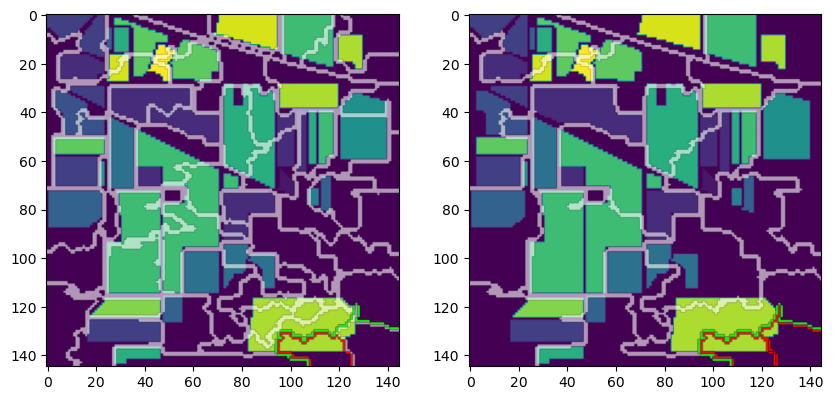

In [23]:
level = np.random.randint(1, len(Ks)-1)
idSP = np.random.randint(0, len(SPsDic[Ks[level]])-1)
SP = getSP(level, idSP)
parentID = getParent[level][idSP]
parent = getSP(level-1, parentID)
childs = [getSP(level, id) for id in getChilds[level-1][parentID]]

print(Ks[level])
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(usedDataset["gt"])
axs[0].imshow(ERS.create_overlay_borders(usedDataset["gt"], SPsDic[Ks[level]], color=[255,255,255,150]))
axs[0].imshow(ERS.create_overlay_borders(usedDataset["gt"], [SP], color=[255,0,0,250]))
axs[0].imshow(ERS.create_overlay_borders(usedDataset["gt"], [parent], color=[0,255,0,250], exterior=True))

axs[1].imshow(usedDataset["gt"])
axs[1].imshow(ERS.create_overlay_borders(usedDataset["gt"], SPsDic[Ks[level-1]], color=[255,255,255,150]))
for child in childs:
    axs[1].imshow(ERS.create_overlay_borders(usedDataset["gt"], [child], color=[255,0,0,250]))
axs[1].imshow(ERS.create_overlay_borders(usedDataset["gt"], [parent], color=[0,255,0,250], exterior=True))
plt.show()

### variability comparaison

In [24]:
def anovaFtest(clusters):
    # High = well separated
    K = len(clusters)
    sizes = [len(cluster) for cluster in clusters]
    n = np.sum(sizes)
    averages = np.array([np.average(cluster, axis=0) for cluster in clusters])
    average = np.average([ts for cluster in clusters for ts in cluster], axis=0)

    BGV = 0
    WGV = 0
    for k in range(K):
        BGV += sizes[k] * ((averages[k]-average)**2).sum()
        for ts in clusters[k]:
            WGV += ((ts-averages[k])**2).sum()
    
    return (n-K)/(K-1) * BGV/WGV
    

from sklearn.metrics import davies_bouldin_score
def DaviesBouldinIndex(clusters):
    # Lower value means better clustering then we invert
    labels = [i for i,cluster in enumerate(clusters) for _ in range(len(cluster))]
    X = [ts for cluster in clusters for ts in cluster]
    return 1/davies_bouldin_score(X, labels)


from sklearn.metrics import silhouette_score
def SilhouetteScore(clusters):
    # Higher value (close to 2) means high separability
    labels = [i for i,cluster in enumerate(clusters) for _ in range(len(cluster))]
    X = [ts for cluster in clusters for ts in cluster]
    return silhouette_score(X, labels)+1


In [28]:
from sklearn.decomposition import PCA

def divide_comp_var(level, idSP, n_component=0, varFun=anovaFtest, do_plot=False):
    childsID = getChilds[level][idSP]
    if len(childsID)==0: return 0
    if len(childsID)==1: return 1e9

    childs = [getSP(level+1, id) for id in childsID]
    if n_component==0:
        return varFun(childs)
    
    clusters_id = [i for i,child in enumerate(childs) for _ in range(len(child))]
    TS = np.array([trainData[coor] for child in childs for coor in child])

    n_component = min(n_component, min(TS.shape))
    pca = PCA(n_components=n_component)
    coeffs = pca.fit_transform(TS)

    if do_plot:
        colors = mpl.colormaps["jet"](np.linspace(0, 1, len(childs)))
        coors = [coor for child in childs for coor in child]
        plt.imshow(usedDataset["gt"])
        mask = ERS.create_overlay_borders(usedDataset["gt"], SPsDic[Ks[level+1]], color=[255,255,255,200])
        for i in range(len(clusters_id)):
            mask[coors[i]] = colors[clusters_id[i]]*255
        plt.imshow(mask)
        plt.show()

        if n_component==3:
            plt.figure().add_subplot(projection="3d")
        for i in range(len(clusters_id)):
            if n_component==3:
                plt.plot(coeffs[i][0], coeffs[i][1], coeffs[i][2], "x", color=colors[clusters_id[i]])
            elif n_component==2:
                plt.plot(coeffs[i][0], coeffs[i][1], "x", color=colors[clusters_id[i]])
            else:
                plt.plot(np.arange(0,n_component), coeffs[i], "x", color=colors[clusters_id[i]])
        plt.show()
    

    clusters = [[] for i in range(len(childs))]
    for i in range(len(clusters_id)):
        clusters[clusters_id[i]].append(coeffs[i])
    #clusters = [np.array(cluster) for cluster in clusters]
    return varFun(clusters)



level = 0
idSP = 5
n_component = 5

do_plot = False
if do_plot:
    plt.imshow(usedDataset["gt"])
    plt.imshow(ERS.create_overlay_borders(usedDataset["gt"], SPsDic[Ks[level+1]], color=[255,255,255,200]))
    plt.imshow(ERS.create_overlay_borders(usedDataset["gt"], [getSP(level, idSP)], color=[255,0,0,200]))
    plt.show()
val = divide_comp_var(level, idSP, n_component, do_plot=do_plot, varFun=SilhouetteScore)
print(val)

1.1145127936163246


### Algorithm

In [40]:
from classes import MinHeap

usedVarFun = anovaFtest
n_component = 0

heap = MinHeap()
for k in range(len(SPsDic[Ks[0]])):
    heap.insert((0, k), -divide_comp_var(0, k, n_component, varFun=usedVarFun))

K = 70
while 0<len(heap.array)<K:
    elt,w = heap.pop()
    level, idSP = elt
    childsID = getChilds[level][idSP]
    if childsID==[]:
        heap.insert((level, idSP), 0)
        break
    for id in childsID:
        heap.insert((level+1, id), -divide_comp_var(level+1, id, n_component, varFun=usedVarFun))
    
    """
    SPs = [getSP(pair.first[0], pair.first[1]) for pair in heap.array]
    plt.imshow(usedDataset["gt"])
    plt.imshow(ERS.create_overlay_borders(usedDataset["gt"], SPs, color=[255,255,255,200]))
    plt.show()
    """




SPs = [getSP(pair.first[0], pair.first[1]) for pair in heap.array]

In [41]:
basic_SPs = ERS.find_superpixel(trainData, K, lambda_coef="auto", simFun="norm1")

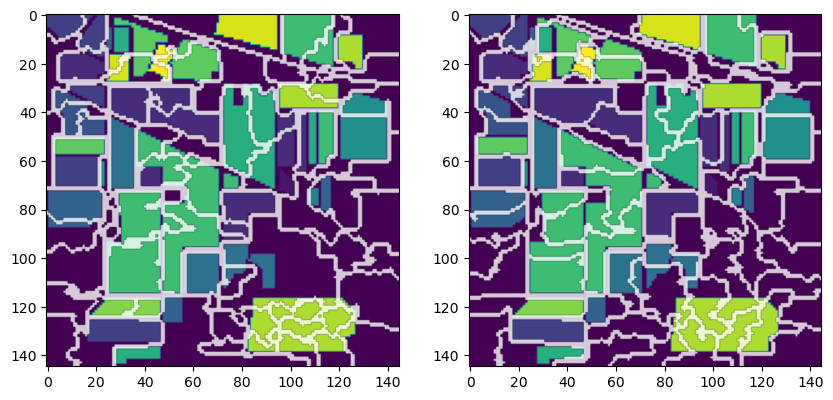

In [42]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(usedDataset["gt"])
axs[0].imshow(ERS.create_overlay_borders(usedDataset["gt"], SPs, color=[255,255,255,200]))

axs[1].imshow(usedDataset["gt"])
axs[1].imshow(ERS.create_overlay_borders(usedDataset["gt"], basic_SPs, color=[255,255,255,200]))
plt.show()

In [44]:
SPs_list = [SPs, basic_SPs]
ClassifierDic:dict[int, list[ERS.SuperpixelClassifier]] = {}
for b in [True, False]:
    ClassifierDic[b] = [
        ERS.SuperpixelClassifier(SPs, usedDataset["labels"], usedDataset["gt"], counting0=b)
                for SPs in SPs_list
        ]

In [ ]:
for b in [True, False]:
    print(b)
    for i in range(len(SPs_list)):
        print(i)
        classifier:ERS.SuperpixelClassifier = ClassifierDic[b][i]
        print("OA:", classifier.overallAccuracy(usedDataset["gt"]))
        print("AA:", classifier.averageAccuracy(usedDataset["gt"]))
        print("SCP:", classifier.singleClassProportion())
        print("ACP:", classifier.averageProportion())
        print("AWJS:", classifier.averageWeightedJaccard(usedDataset["gt"], usedDataset["class"]))


True
0
OA: 0.7668489892984542
AA: 0.5172265312912957
SCP: 0.21428571428571427
ACP: 0.7911663065314036
1
OA: 0.7814982164090368
AA: 0.5778810123468356
SCP: 0.22857142857142856
ACP: 0.7840273556068648
False
0
OA: 0.8800858620353205
AA: 0.7217384092474373
SCP: 0.6666666666666666
ACP: 0.9079980585837161
1
OA: 0.9135525417113864
AA: 0.7356646543789935
SCP: 0.6481481481481481
ACP: 0.918483871359594
